# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Импорт необходимых библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
import warnings
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.tokens import Token
from tqdm.notebook import tqdm
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
tqdm.pandas()
warnings.filterwarnings('ignore')
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

# pip install pandarallel
# pip install modin
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Загрузка данных
data = pd.read_csv('/datasets/toxic_comments.csv',index_col=0)
display(data.sample(5))
data.info()

,text,toxic
37584,September 2011 (UTC)\nTo hell with it. See my ...,0
42298,You appear to be an idiot. These are legitimat...,1
38772,"The Juggernaut, Bitch!! \n\nI think the line a...",1
103823,"""\n\nManchus\n\nIn April you reverted my edits...",0
1566,targeting any dissent. No doubt 86.149.148.121...,0


<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [4]:
# Количество общих дубликатов
data.duplicated().sum()

0

In [5]:
# Распределение данных в столбце toxic
data['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

Text(0.5, 0, '0 - нетоксичный, 1 - токсичный')

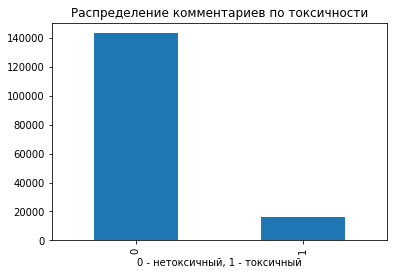

In [6]:
data['toxic'].value_counts().plot(kind='bar')
plt.title('Распределение комментариев по токсичности')
plt.xlabel('0 - нетоксичный, 1 - токсичный')

In [9]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clear_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    return ' '.join(text.split())

def lemmatize_text(text):
    m = WordNetLemmatizer()
    txt_list =  nltk.word_tokenize(text)
    return ' '.join([m.lemmatize(word,get_wordnet_pos(word)) for word in txt_list])

In [10]:
# Попробую на примере
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df = pd.DataFrame([sentence1, sentence2], columns = ['text'])

# df['lemm_text'] = df['text'].parallel_apply(lambda x: lemmatize_text(clear_text(x)))
df['lemm_text'] = df['text'].progress_apply(lambda x: lemmatize_text(clear_text(x)))
df

  0%|          | 0/2 [00:00<?, ?it/s]

,text,lemm_text
0,The striped bats are hanging on their feet for...,the strip bat be hang on their foot for best
1,you should be ashamed of yourself went worked,you should be ashamed of yourself go work


In [11]:
# Лемматизирую исходный текст
# data['lemm_text'] = data['text'].parallel_apply(lambda x: lemmatize_text(clear_text(x)))
data['lemm_text'] = data['text'].progress_apply(lambda x: lemmatize_text(clear_text(x)))
data

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i 'm really not try to edit war it 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159446,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159447,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159448,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159449,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


In [12]:
data = data.drop('text',axis=1)
data

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d'aww he match this background colour i 'm see...
2,0,hey man i 'm really not try to edit war it 's ...
3,0,more i ca n't make any real suggestion on impr...
4,0,you sir be my hero any chance you remember wha...
...,...,...
159446,0,and for the second time of ask when your view ...
159447,0,you should be ashamed of yourself that be a ho...
159448,0,spitzer umm there no actual article for prosti...
159449,0,and it look like it be actually you who put on...


## Обучение

### Обучение моделей

Для обучения выберу следующие модели:
- LogisticRegression
- DecisionTreeClassifier
- CatBoostClassifier

Проведу подбор параметров с помощью GridSearch. 
И для начала подготовлю выборки - тренировочную и тестовую.

In [13]:
%%time

# Подготовка выборок

target = data['toxic']
features = data.drop(['toxic'], axis=1)
train, test = train_test_split(data, test_size=0.1, random_state=12345,stratify=target)

target_train = train['toxic']
features_train = train['lemm_text']

target_test = test['toxic']
features_test = test['lemm_text']

stopwords_ = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords_)
tf_idf = count_tf_idf.fit_transform(tqdm(features_train))
tf_idf_test = count_tf_idf.transform(features_test)
print(features_train.shape)
print(features_test.shape)

  0%|          | 0/143362 [00:00<?, ?it/s]

(143362,)
(15930,)
CPU times: user 6.53 s, sys: 226 ms, total: 6.76 s
Wall time: 7.01 s


In [14]:
%%time

# Логистическая регрессия
model = LogisticRegression()
hyperparams = [{'C':[0.5, 1, 5]}]

clf_LR = GridSearchCV(model, hyperparams, scoring='f1')
clf_LR.fit(tf_idf, target_train)
print("Лучшие параметры:")
LR_best_params = clf_LR.best_params_
print(LR_best_params)
print("Результаты кросс-валидации:")
print()
means = clf_LR.cv_results_['mean_test_score']
stds = clf_LR.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_LR.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))

results = clf_LR.cv_results_
mean_fit_time_LR = results['mean_fit_time']
mean_score_time_LR = results['mean_score_time']
best_f1_LR = clf_LR.best_score_

Лучшие параметры:
{'C': 5}
Результаты кросс-валидации:

0.684050 for {'C': 0.5}
0.722641 for {'C': 1}
0.762521 for {'C': 5}
CPU times: user 5min 29s, sys: 5min 45s, total: 11min 15s
Wall time: 11min 15s


In [15]:
%%time

# DecisionTreeClassifier
model = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(5,10,20)]}]

clf_DT = GridSearchCV(model, hyperparams, scoring='f1')
clf_DT.fit(tf_idf, target_train)
print("Лучшие параметры:")
DT_best_params = clf_DT.best_params_
print(DT_best_params)
print("Результаты кросс-валидации:")
print()
means = clf_DT.cv_results_['mean_test_score']
stds = clf_DT.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_DT.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))

results = clf_DT.cv_results_
mean_fit_time_DT = results['mean_fit_time']
mean_score_time_DT = results['mean_score_time']
best_f1_DT = clf_DT.best_score_

Лучшие параметры:
{'max_depth': 5}
Результаты кросс-валидации:

0.541217 for {'max_depth': 5}
CPU times: user 1min 4s, sys: 306 ms, total: 1min 5s
Wall time: 1min 5s


In [16]:
%%time

# CatBoostClassifier
model = CatBoostClassifier(verbose=False)
hyperparams = [{'iterations':[50,100,200]}]

clf_CB = GridSearchCV(model, hyperparams, scoring='f1')
clf_CB.fit(tf_idf, target_train)
print("Лучшие параметры:")
CB_best_params = clf_CB.best_params_
print(CB_best_params)
print("Результаты кросс-валидации:")
print()
means = clf_CB.cv_results_['mean_test_score']
stds = clf_CB.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf_CB.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))

results = clf_CB.cv_results_
mean_fit_time_CB = results['mean_fit_time']
mean_score_time_CB = results['mean_score_time']
best_f1_CB = clf_CB.best_score_

Лучшие параметры:
{'iterations': 200}
Результаты кросс-валидации:

0.716742 for {'iterations': 50}
0.738749 for {'iterations': 100}
0.740838 for {'iterations': 200}
CPU times: user 1h 4min 52s, sys: 39 s, total: 1h 5min 31s
Wall time: 1h 5min 40s


In [17]:
# Сведу все полученные результаты в одном месте
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'Время обучения, сек':[mean_fit_time_LR[2],
                              mean_fit_time_DT[0],
                              mean_fit_time_CB[2]],
        'Время предсказания, сек':[mean_score_time_LR[2],
                                  mean_score_time_DT[0],
                                  mean_score_time_CB[2]],
        'F1':[best_f1_LR,
                best_f1_DT,
                best_f1_CB]}
scores_data = pd.DataFrame(data=data, index=index)
scores_data.sort_values(by='F1',ascending=False)

,"Время обучения, сек","Время предсказания, сек",F1
LogisticRegression,43.782590,0.155983,0.762521
CatBoostClassifier,375.065120,0.359143,0.740838
DecisionTreeClassifier,12.502696,0.034760,0.541217


Я подобрал параметры у трех моделей с помощью GridSearch.

Лучшая модель по метрике F1 - логистическая регрессия. Время обучения и предсказания приемлемое, лучше чем у CatBoost, самой долгой модели.

Теперь проверю лучшую модель на тестовой выборке с применением лучших найденных параметров. На тестовой выборке проверю логистическую регрессию и оценю ее F1.

### Тестирование лучшей модели

In [18]:
%%time

# Обучение
# model = LogisticRegression(C=5)
# model.best_estimator_
# model.fit(tf_idf, target_train)
best_estimator = clf_LR.best_estimator_

# Предсказание
prediction_lr = best_estimator.predict(tf_idf_test)

# Метрика RMSE
final_f1_LR = f1_score(target_test, prediction_lr)
final_f1_LR

CPU times: user 9.2 ms, sys: 98 µs, total: 9.29 ms
Wall time: 9.07 ms


0.7816411682892905

**Выводы**

Метрика F1 на тестовых данных даже чуть улушилась.

## Выводы

- Данные загружены и лемматизирован текстовой столбец
- Проведел обучение трех моделей: LogisticRegression, DecisionTreeClassifier, CatBoostClassifier
- Провел подбор параметров с помощью GridSearch
- Лучшая модель - логистическая регрессия
- На тестировании лучшей модели метрика F1 чуть-чуть улушилась